In [2]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys
import tomoalign
from skimage.metrics import structural_similarity as ssim
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline


In [3]:
cp.cuda.Device(0).use()
ntheta = 180  # number of angles (rotations)
ptheta = 180  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
ndist = 4
st = 0
same_probe = True
flg_show = True

theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


cropx_left = 0
cropx_right = 0
cropy_up = 0
cropy_down = 0

# cropx_left = 256
# cropx_right = 256
# cropy_up = 256
# cropy_down = 256

n = (256-cropx_left-cropx_right)//2**binning

ne = 512//2**binning

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 

512


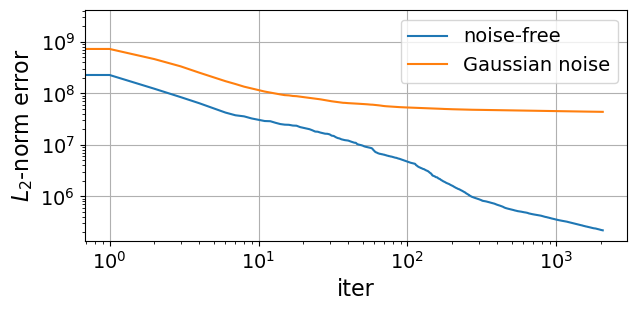

In [33]:
c = np.load(f'/data/vnikitin/holo/3d_ald_syn/conv_{n}_{ntheta}_{ndist}_{st}.npy')
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.plot(np.arange(0,2048),c[:2048],label='noise-free')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('$L_2$-norm error',fontsize=16)
plt.xlabel('iter',fontsize=16)
plt.savefig(f'figs/conv.png',dpi=300,bbox_inches='tight')

c = np.load(f'/data/vnikitin/holo/3d_ald_syn/conv_{n}_{ntheta}_{ndist}_{st}noise.npy')
# fig = plt.figure(figsize=(7,3))
# ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
ax.loglog(np.arange(0,2048),c[:2048],label='Gaussian noise')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('$L_2$-norm error',fontsize=16)
plt.xlabel('iter',fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.savefig(f'figs/convnoise.png',dpi=300,bbox_inches='tight')


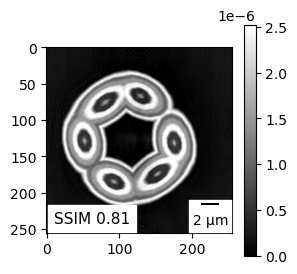

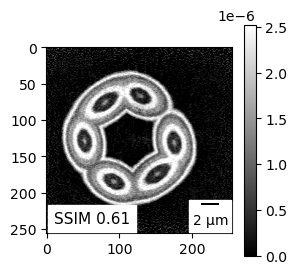

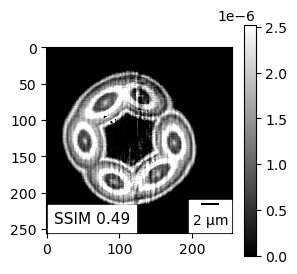

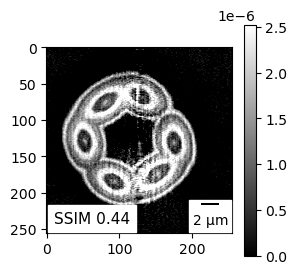

In [31]:

iter = 2048

offset = 8
rec = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}/cgfull/r_{iter:04}.tiff')
delta = dxchange.read_tiff('/data/vnikitin/modeling/3d_ald_syn/delta.tiff')

rec = rec[ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
#for k in range (20,40):
rec=rec-np.mean(rec[n//6:-n//6,n//2-offset,n//6:-n//6]-delta[n//6:-n//6,n//2-offset,n//6:-n//6])
# rec=rec-np.mean(rec[n//4:-n//4,n//2,n//4:-n//4]-delta[n//4:-n//4,n//2,n//4:-n//4])

    #s = ssim(rec[n//4:-n//4,n//2-offset,n//4:-n//4],delta[n//4:-n//4,n//2-offset,n//4:-n//4],data_range=np.amax(delta)-np.amin(delta))
s = ssim(rec[n//6:-n//6,n//2-offset,n//6:-n//6],delta[n//6:-n//6,n//2-offset,n//6:-n//6],data_range=np.amax(delta)-np.amin(delta))
# print(k,s)
err = np.linalg.norm(rec[:,n//2-offset,:]-delta[:,n//2-offset,:])/np.linalg.norm(delta[:,n//2-offset,:])

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-rec[:,n//2-offset,:],cmap='gray',vmax=2.526992e-06,vmin=0)
plt.text(10,242,f'SSIM {s:.2}',backgroundcolor='w',size=11)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig(f'figs/recv{iter}.png',dpi=300,bbox_inches='tight')

############################################
iter = 2048
rec = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}/cgfull/r_{iter:04}noise.tiff')
delta = dxchange.read_tiff('/data/vnikitin/modeling/3d_ald_syn/delta.tiff')

rec = rec[ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
rec=rec+np.mean(delta[:,n//2-offset,:]-rec[:,n//2-offset,:])

#s = ssim(rec[n//4:-n//4,n//2-offset,n//4:-n//4],delta[n//4:-n//4,n//2-offset,n//4:-n//4],data_range=np.amax(delta)-np.amin(delta))
s = ssim(rec[n//6:-n//6,n//2,n//6:-n//6],delta[n//6:-n//6,n//2,n//6:-n//6],data_range=np.amax(delta)-np.amin(delta))
err = np.linalg.norm(rec[:,n//2-offset,:]-delta[:,n//2-offset,:])/np.linalg.norm(delta[:,n//2-offset,:])

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-rec[:,n//2-offset,:],cmap='gray',vmax=2.526992e-06,vmin=0)
plt.text(10,242,f'SSIM {s:.2}',backgroundcolor='w',size=11)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig(f'figs/recv{iter}noise.png',dpi=300,bbox_inches='tight')


############################################
iter = 2048
rec = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn_noprobe/r_{n}_{ntheta}_{ndist}/cgfull/r_{iter:04}.tiff')
delta = dxchange.read_tiff('/data/vnikitin/modeling/3d_ald_syn/delta.tiff')

rec = rec[ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
rec=rec+np.mean(delta[:,n//2-offset,:]-rec[:,n//2-offset,:])+0.5e-6

#s = ssim(rec[n//4:-n//4,n//2-offset,n//4:-n//4],delta[n//4:-n//4,n//2-offset,n//4:-n//4],data_range=np.amax(delta)-np.amin(delta))
s = ssim(rec[n//6:-n//6,n//2,n//6:-n//6],delta[n//6:-n//6,n//2,n//6:-n//6],data_range=np.amax(delta)-np.amin(delta))
err = np.linalg.norm(rec[:,n//2-offset,:]-delta[:,n//2-offset,:])/np.linalg.norm(delta[:,n//2-offset,:])

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-rec[:,n//2-offset,:],cmap='gray',vmax=2.526992e-06,vmin=0)
plt.text(10,242,f'SSIM {s:.2}',backgroundcolor='w',size=11)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig(f'figs/recv{iter}noprobe.png',dpi=300,bbox_inches='tight')

############################################
iter = 2048+1024
rec = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn_noprobe_noise/r_{n}_{ntheta}_{ndist}/cgfull/r_{iter:04}.tiff')
delta = dxchange.read_tiff('/data/vnikitin/modeling/3d_ald_syn/delta.tiff')

rec = rec[ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
rec=rec+np.mean(delta[:,n//2-offset,:]-rec[:,n//2-offset,:])+0.2e-6

#s = ssim(rec[n//4:-n//4,n//2-offset,n//4:-n//4],delta[n//4:-n//4,n//2-offset,n//4:-n//4],data_range=np.amax(delta)-np.amin(delta))
s = ssim(rec[n//6:-n//6,n//2,n//6:-n//6],delta[n//6:-n//6,n//2,n//6:-n//6],data_range=np.amax(delta)-np.amin(delta))
err = np.linalg.norm(rec[:,n//2-offset,:]-delta[:,n//2-offset,:])/np.linalg.norm(delta[:,n//2-offset,:])

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-rec[:,n//2-offset,:],cmap='gray',vmax=2.526992e-06,vmin=0)
plt.text(10,242,f'SSIM {s:.2}',backgroundcolor='w',size=11)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig(f'figs/recv{iter}noprobenoise.png',dpi=300,bbox_inches='tight')

TypeError: FontProperties.__init__() got an unexpected keyword argument 'fontsize'

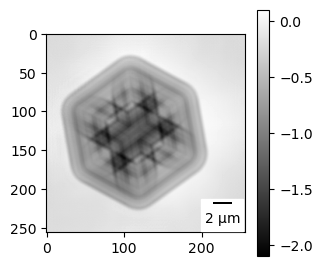

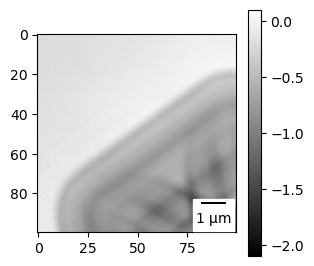

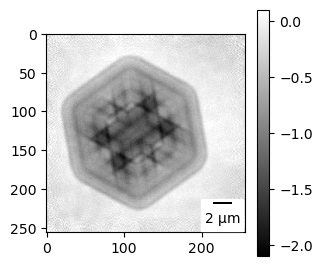

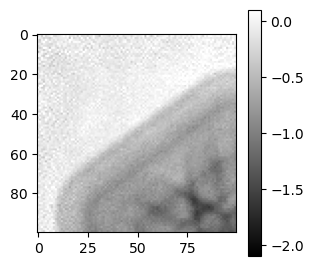

In [14]:

iter = 2048
vvmin = -2.1
vvmax = 0.1
add = np.array([0.3,0,0.0,0.0])-0.5
psi = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}_{st}/r{iter:05}.tiff')
psi = psi[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]+add[0]
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(psi[0//2],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psirec_angle.png',dpi=300,bbox_inches='tight')
stx = 10
sty = 10
lenx = 100
leny = 100
for k in range(1):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(psi[0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=vvmin,vmax=vvmax)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize,location='lower right',length_fraction=.25))
    plt.savefig(f'figs/psirec_angles.png',dpi=300,bbox_inches='tight')


iter = 2048
psi = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn/r_{n}_{ntheta}_{ndist}_{st}/r{iter:05}noise.tiff')
psi = psi[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]+add[1]
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(psi[0//2],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psirec_angle_noise.png',dpi=300,bbox_inches='tight')
stx = 10
sty = 10
lenx = 100
leny = 100
for k in range(1):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(psi[0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=vvmin,vmax=vvmax)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize,location='lower right',length_fraction=.25))
    plt.savefig(f'figs/psirec_angles_noise.png',dpi=300,bbox_inches='tight')


iter = 128
psi = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn_noprobe_noise/r_{n}_{ntheta}_{ndist}_{st}/r{iter:05}.tiff')
psi = psi[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]+add[2]
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(psi[0//2],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psirec_angle_noprobe.png',dpi=300,bbox_inches='tight')
stx = 10
sty = 10
lenx = 100
leny = 100
for k in range(1):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(psi[0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=vvmin,vmax=vvmax)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize,location='lower right',length_fraction=.25))
    plt.savefig(f'figs/psirec_angles_noprobe.png',dpi=300,bbox_inches='tight')

iter = 128
psi = dxchange.read_tiff(f'/data/vnikitin/holo/3d_ald_syn_noprobe_noise/r_{n}_{ntheta}_{ndist}_{st}/r{iter:05}.tiff')
psi = psi[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]+add[3]
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(psi[0//2],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psirec_angle_noprobe_noise.png',dpi=300,bbox_inches='tight')
stx = 10
sty = 10
lenx = 100
leny = 100
for k in range(1):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(psi[0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=vvmin,vmax=vvmax)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize,location='lower right',length_fraction=.25))
    plt.savefig(f'figs/psirec_angles_noprobe_noise.png',dpi=300,bbox_inches='tight')
